In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools.tools import get_positive_contributions, compute_entropy, print_equations, compute_gram_matrix_for_sindy
from data_generators.data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)


pipline操作流程：

1.生成数据：a 单起始点时间序列；b 多起始点时间序列

可选步骤：时间序列降采样

2.选择合适的library做观测

3.选择合适的optimizer做拟合：a 离散的迭代方程；b 连续的微分方程

4.计算score，多步预测效果看一下

5.提取系数矩阵，进行svd分解，得到奇异值谱和左奇异向量

6.观察奇异值谱截断，计算因果涌现程度，绘制多尺度contribution，计算EC

7.根据奇异向量和谱截断，输出粗粒化函数表达式

8.绘制宏观演化的时间序列，给出宏观动力学方程

可选的分析案例：

1.SIR：原始的SIR动力学；带观测噪音的四维微观数据

2.kuramoto模型

3.洛伦兹动力学

4.耦合Rulkov映射

# 数据生成

In [2]:
N=10
n_clusters=2  # 团数
K_intra=5
K_inter=0.11
noise=0
dt=0.01

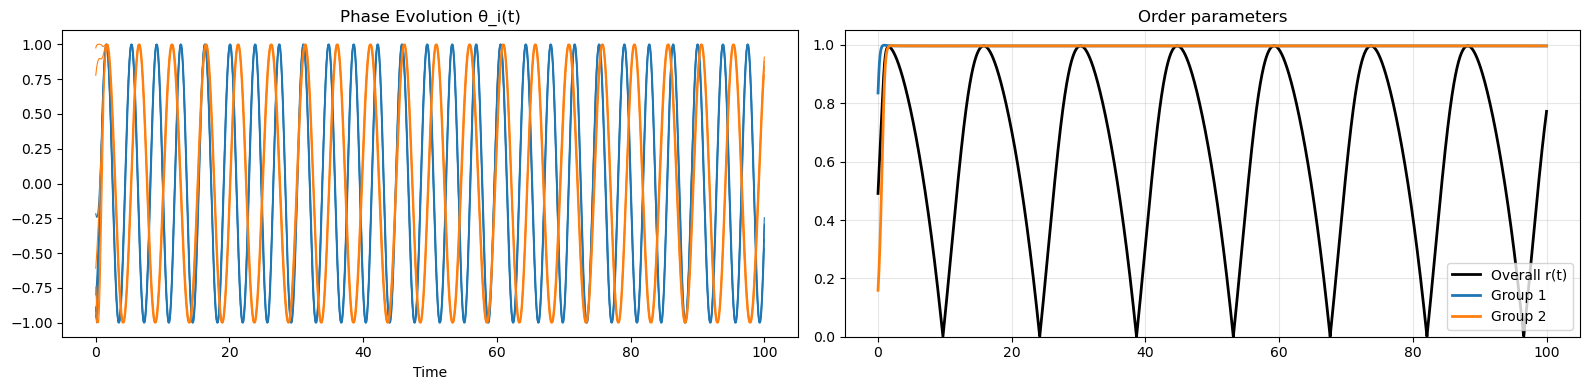

In [3]:
# 单时间序列采样
x_train, theta_hist, t_train, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)

x_data = x_train


# 选择library

In [4]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=2,include_bias=False)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide + fourier

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(10000, 60)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'sin(1 x0)', 'cos(1 x0)', 'sin(1 x1)', 'cos(1 x1)', 'sin(1 x2)', 'cos(1 x2)', 'sin(1 x3)', 'cos(1 x3)', 'sin(1 x4)', 'cos(1 x4)', 'sin(1 x5)', 'cos(1 x5)', 'sin(1 x6)', 'cos(1 x6)', 'sin(1 x7)', 'cos(1 x7)', 'sin(1 x8)', 'cos(1 x8)', 'sin(1 x9)', 'cos(1 x9)', 'sin(1 x10)', 'cos(1 x10)', 'sin(1 x11)', 'cos(1 x11)', 'sin(1 x12)', 'cos(1 x12)', 'sin(1 x13)', 'cos(1 x13)', 'sin(1 x14)', 'cos(1 x14)', 'sin(1 x15)', 'cos(1 x15)', 'sin(1 x16)', 'cos(1 x16)', 'sin(1 x17)', 'cos(1 x17)', 'sin(1 x18)', 'cos(1 x18)', 'sin(1 x19)', 'cos(1 x19)']


检测到 1 条轨迹
各轨迹时间步数: [10000]
总样本数 M = 10000
观测函数个数 N = 60
使用均匀权重（所有样本等权重）
Gram 矩阵形状: (60, 60)
Gram矩阵形状: (60, 60)
Gram矩阵:
[[ 5.00015889e-01  4.91085592e-01  4.97237881e-01 ... -1.23722292e-03
  -6.42663311e-02 -2.58118137e-03]
 [ 4.91085592e-01  4.98013086e-01  4.96980561e-01 ...  1.73819878e-03
  -6.48476399e-02  2.72825004e-04]
 [ 4.97237881e-01  4.96980561e-01  4.99361196e-01 ... -6.31776473e-04
  -6.48699068e-02 -1.90552001e-03]
 ...
 [-1.23722292e-03  1.73819878e-03 -6.31776473e-04 ...  6.16708910e-01
  -5.61883594e-03  6.13537871e-01]
 [-6.42663311e-02 -6.48476399e-02 -6.48699068e-02 ... -5.61883594e-03
   3.88221387e-01 -3.55648672e-03]
 [-2.58118137e-03  2.72825004e-04 -1.90552001e-03 ...  6.13537871e-01
  -3.55648672e-03  6.11778613e-01]]

矩阵是否对称: True
矩阵条件数: 84284901629961936.0000
矩阵特征值: [1.17122923e+01 5.03358973e+00 5.04525801e+00 3.82690291e+00
 3.77115826e+00 2.60013686e-01 2.50764948e-01 6.33637752e-02
 1.26580184e-02 7.50144540e-03 6.40907217e-03 2.31200117e-03
 2.34537911

<Axes: >

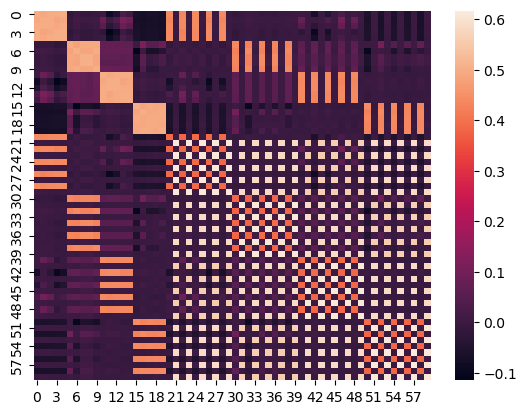

In [5]:
G = compute_gram_matrix_for_sindy(library, [x_data])

print(f"Gram矩阵形状: {G.shape}")
print(f"Gram矩阵:\n{G}")
print(f"\n矩阵是否对称: {np.allclose(G, G.T)}")
print(f"矩阵条件数: {np.linalg.cond(G):.4f}")
print(f"矩阵特征值: {np.linalg.eigvals(G)}")
sns.heatmap(G)

# 进行拟合

In [8]:
x_data_lift.shape

(10000, 60)

In [13]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=False
t_array = np.arange(x_data_lift.shape[0]) * dt
# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l2")
lasso_optimizer = Lasso(alpha=0.01, max_iter=20000, fit_intercept=False)
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=0.9, verbose=True)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit([x_data_lift], t=[t_array], feature_names=names)
model.print()

ValueError: solve: Input operand 1 does not have enough dimensions (has 1, gufunc core with signature (m,m),(m,n)->(m,n) requires 2)

In [26]:
# 计算score
model.score(x_data_lift, t=dt)

0.8642429291754818

# 多步预测

In [28]:
test_idx = 0
init_data = x_data_lift[0,:]
step_pred = 20
t = range(step_pred)

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(20, 60)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_92382/2308130201.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


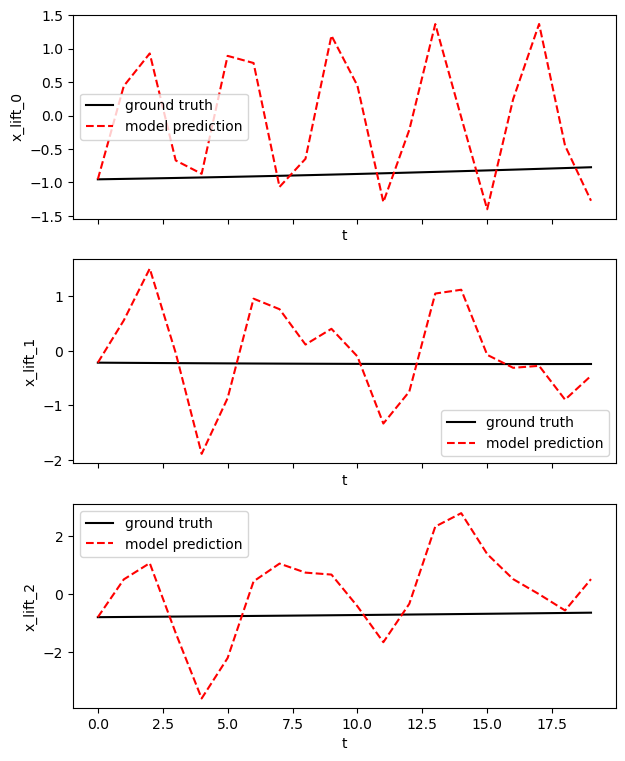

In [29]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# svd分解

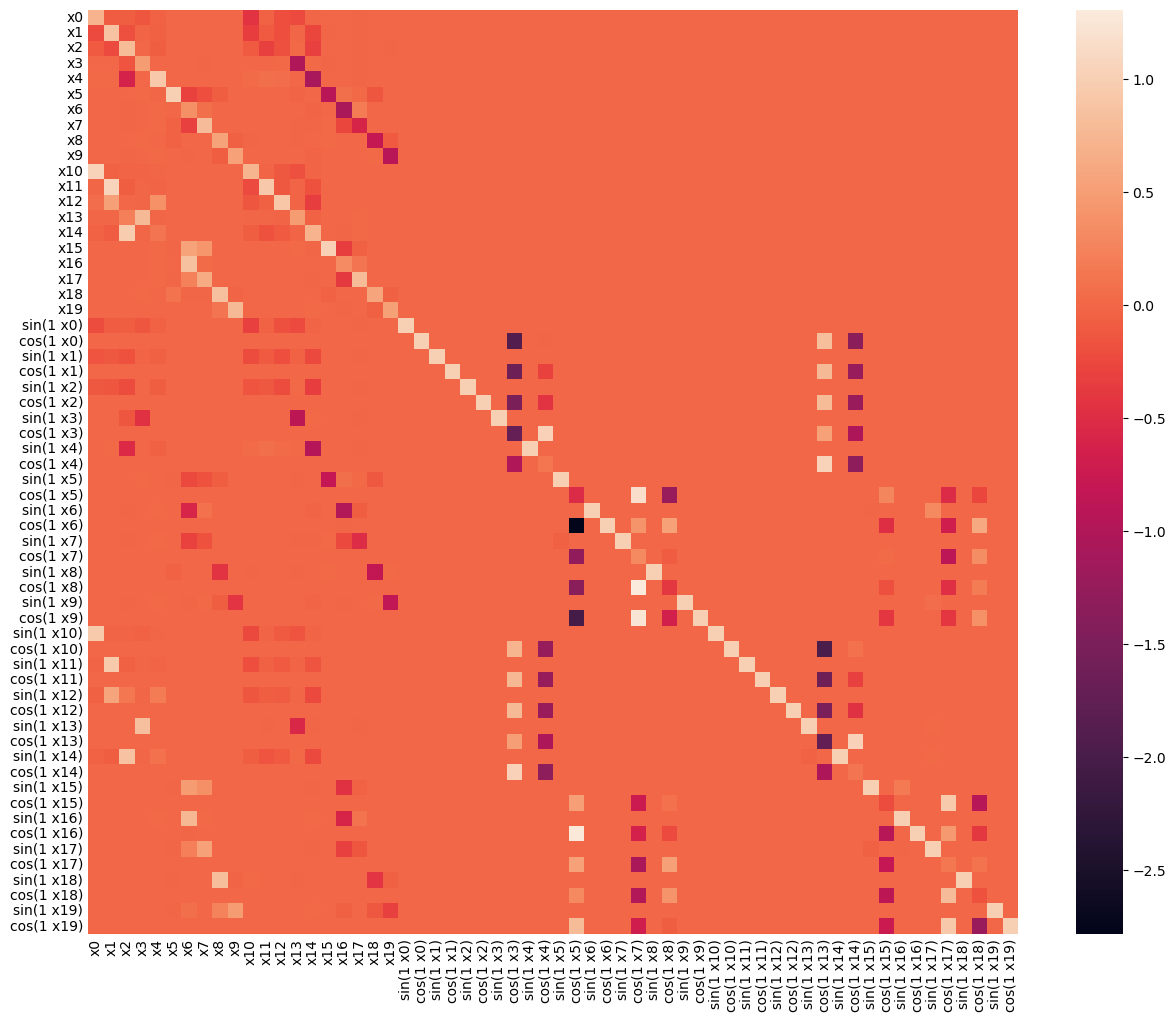

In [ ]:
from scipy.linalg import sqrtm

A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

G_sqrt = sqrtm(G).real
G_inv_sqrt = sqrtm(np.linalg.inv(G)).real
A = G_sqrt @ A @ G_inv_sqrt

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

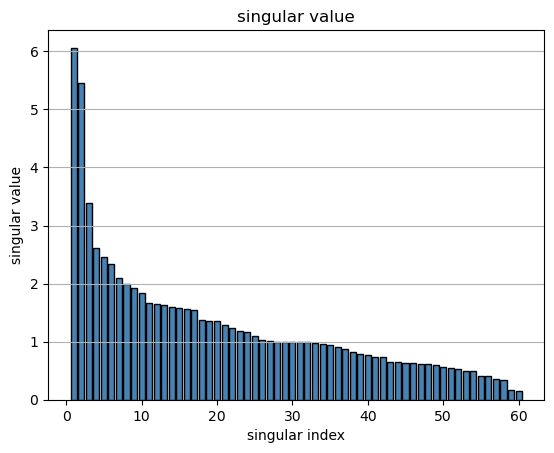

In [15]:
# SVD
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

In [19]:
# 选取截断
rank = 2
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

4.489796119502212


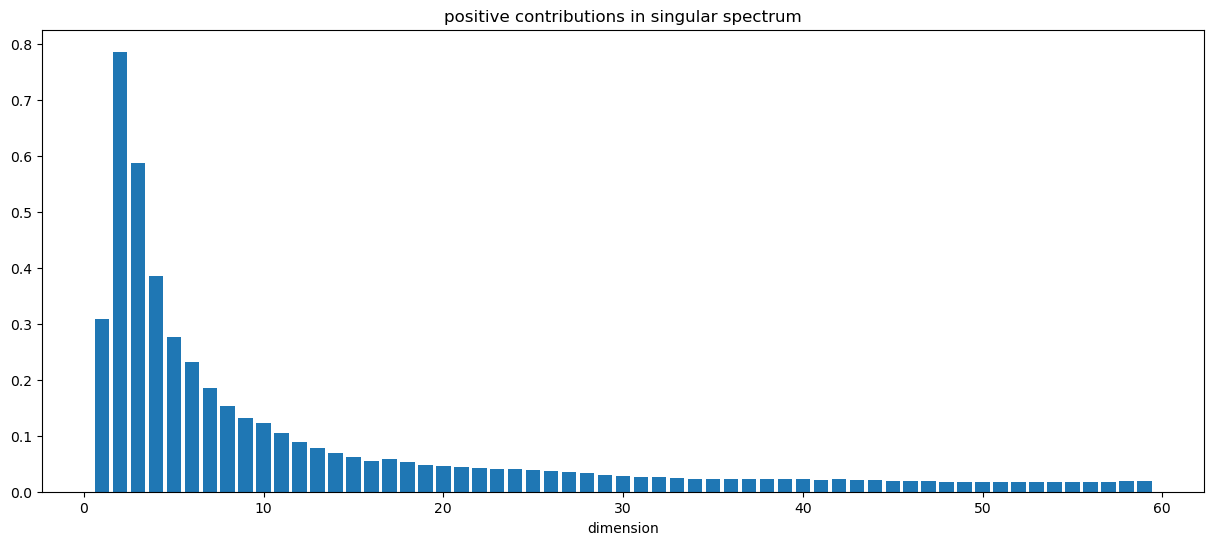

In [20]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [21]:
# 计算EC
print(compute_entropy(diff))

4.771670063172314


# 输出粗粒化表达式

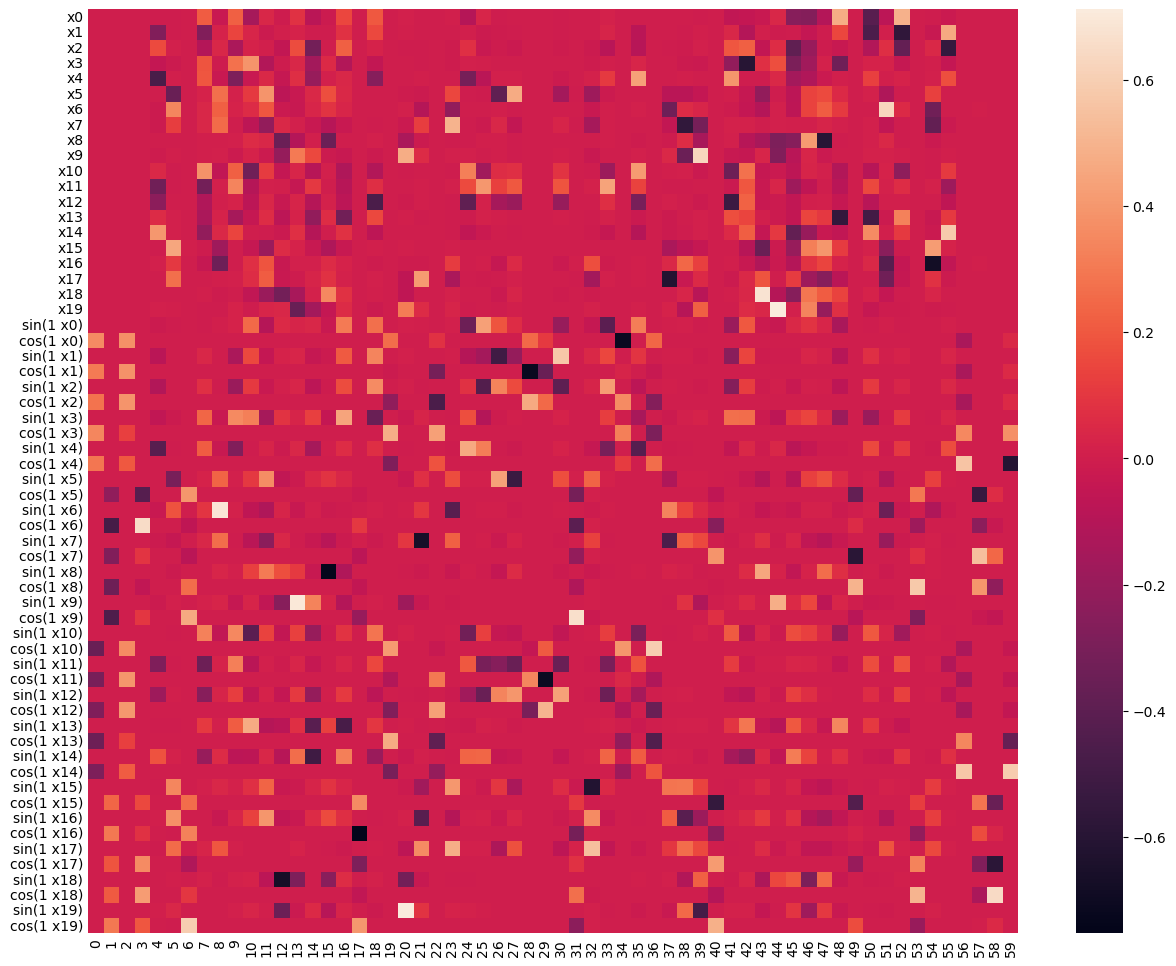

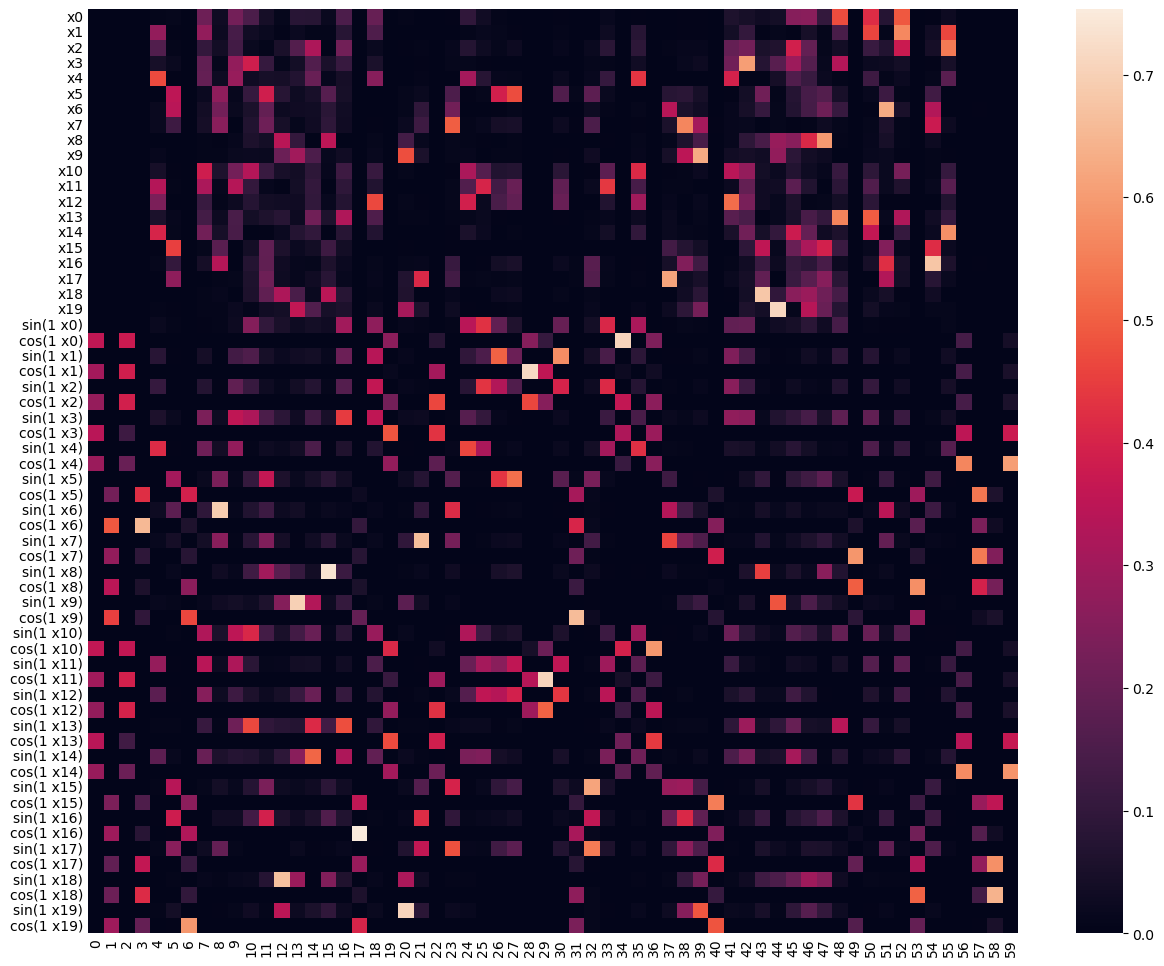

In [22]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

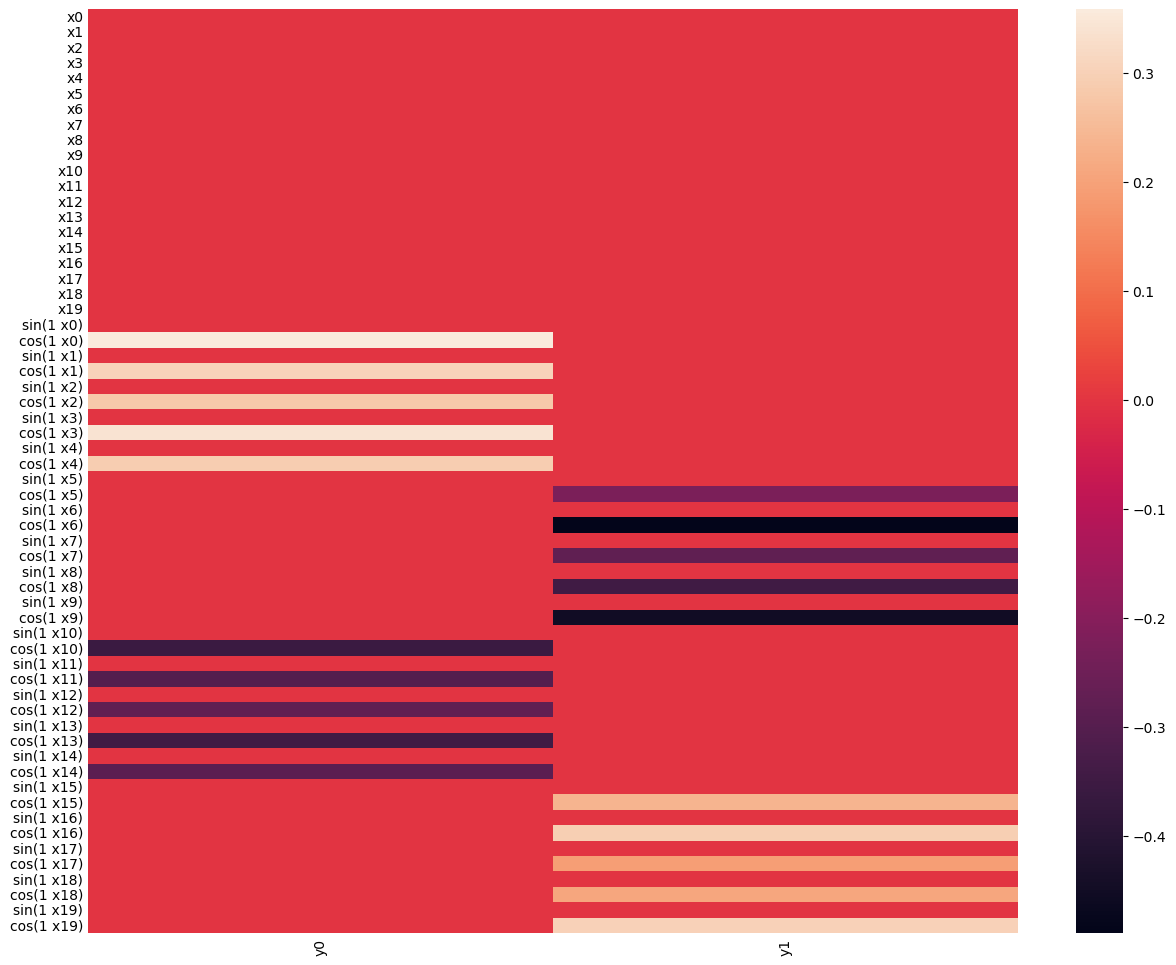

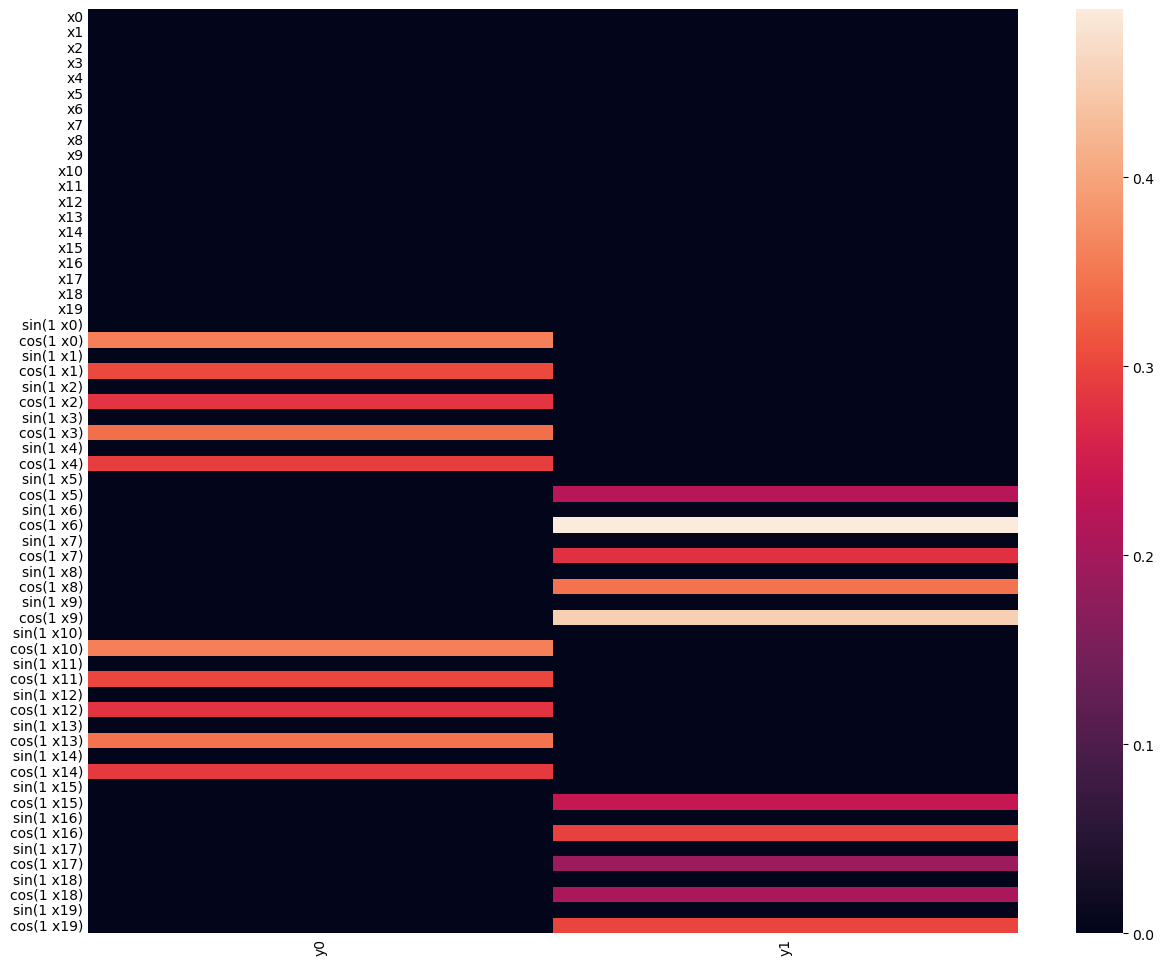

In [23]:
# 粗粒化函数系数
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [24]:
# 输出粗粒化函数表达式
print_equations(coarse_grain_coff, names, macro_name)

y0 = 0.3586 * cos(1 x0) + 0.3035 * cos(1 x1) + 0.2821 * cos(1 x2) + 0.3415 * cos(1 x3) + 0.2910 * cos(1 x4) - 0.3578 * cos(1 x10) - 0.3014 * cos(1 x11) - 0.2793 * cos(1 x12) - 0.3442 * cos(1 x13) - 0.2883 * cos(1 x14)
------------------------------
y1 = 0.0001 * x5 - 0.0003 * x6 + 0.0000 * x7 - 0.0002 * x15 - 0.0002 * x16 - 0.0002 * x17 + 0.0001 * sin(1 x5) - 0.2224 * cos(1 x5) - 0.0001 * sin(1 x6) - 0.4890 * cos(1 x6) + 0.0000 * sin(1 x7) - 0.2773 * cos(1 x7) - 0.3444 * cos(1 x8) - 0.4518 * cos(1 x9) - 0.0002 * sin(1 x15) + 0.2383 * cos(1 x15) - 0.0003 * sin(1 x16) + 0.2948 * cos(1 x16) - 0.0001 * sin(1 x17) + 0.1899 * cos(1 x17) + 0.2064 * cos(1 x18) - 0.0000 * sin(1 x19) + 0.2992 * cos(1 x19)
------------------------------


# 描述宏观演化

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_95828/580934310.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


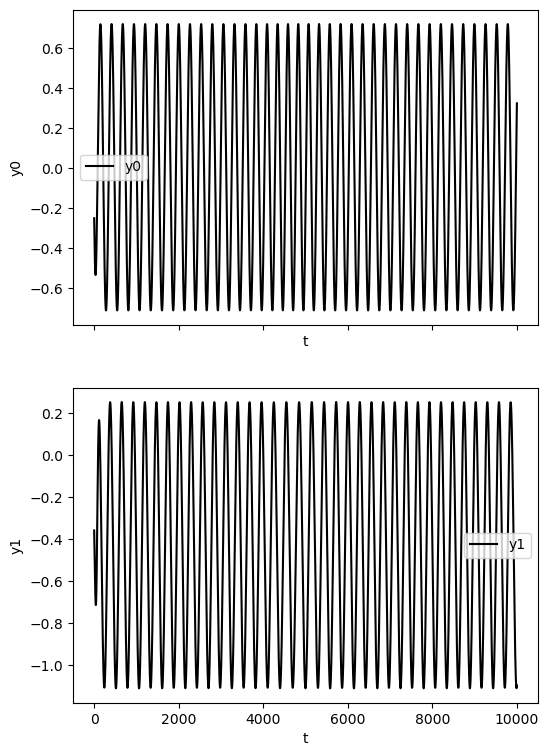

In [25]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

In [26]:
# 给出宏观动力学方程
A_macro = coarse_grain_coff.T @ A @ coarse_grain_coff
macro_name_k = [i+'[k]' for i in macro_name]
macro_name_next = [i+'[k+1]' for i in macro_name]
print_equations(A_macro, macro_name_k, macro_name_next)

y0[k+1] = -0.7256 * y0[k]
------------------------------
y1[k+1] = 0.1829 * y1[k]
------------------------------


# 频谱分析

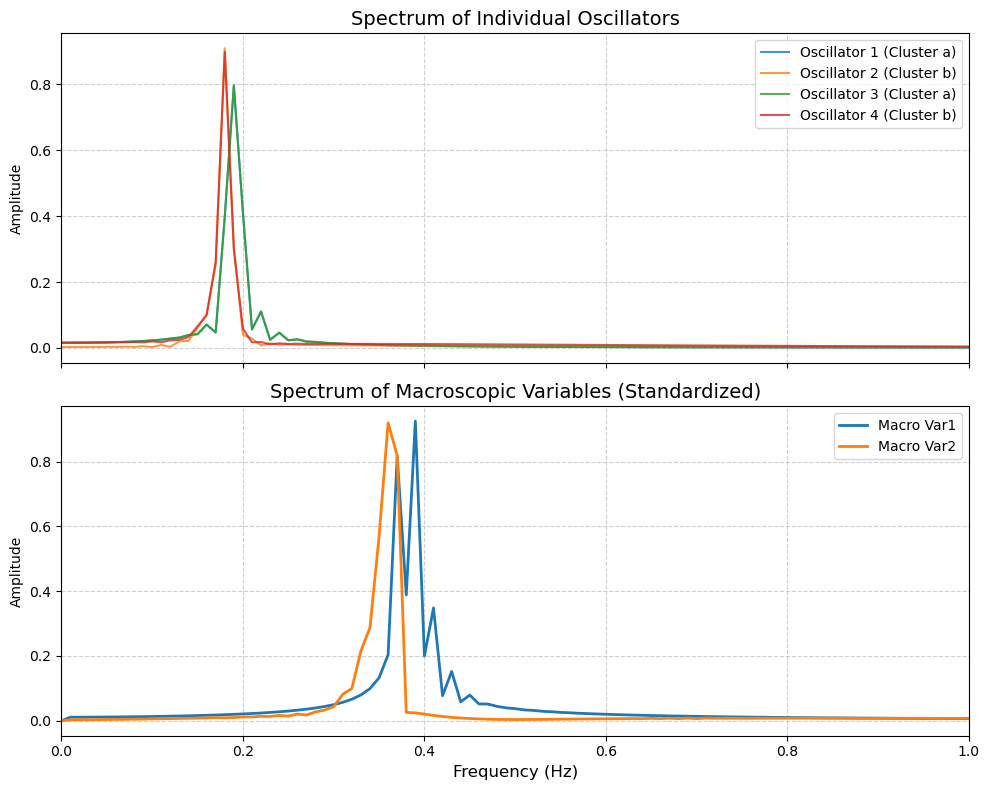

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

N=len(macro_data[:,0])
xf = np.fft.fftfreq(N, dt) 

micro_signals = [x_data[:, 0], x_data[:, 5], x_data[:, 1], x_data[:, 6]]
micro_labels = [
    'Oscillator 1 (Cluster a)', 
    'Oscillator 2 (Cluster b)', 
    'Oscillator 3 (Cluster a)', 
    'Oscillator 4 (Cluster b)'
]

# 扩充 Colors：使用不同颜色区分不同指标，或同色系区分不同集群
# 这里补充了绿色和红色，分别对应蓝、橙、绿、红
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] 

macro_signals = []
for i in range(macro_dim):
    sig = macro_data[:,i]
    standardized_sig = (sig - np.mean(sig) ) / np.std(sig)
    macro_signals.append(standardized_sig)
macro_labels = ['Macro Var1', 'Macro Var2', 'Macro Var3']

def compute_fft(signal, xf, N):
    yf = fft(signal)
    half_n = N // 2
    return xf[:half_n], np.abs(yf[:half_n]) / N * 2  # 归一化幅值


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- 第一幅图：原振子数据的频谱 ---
for i, sig in enumerate(micro_signals):
    freqs, amps = compute_fft(sig, xf, N)
    ax1.plot(freqs, amps, label=micro_labels[i], color=colors[i], alpha=0.8)

ax1.set_title("Spectrum of Individual Oscillators", fontsize=14)
ax1.set_ylabel("Amplitude")
ax1.legend(loc="upper right")
ax1.grid(True, linestyle='--', alpha=0.6)

# --- 第二幅图：宏观变量的频谱 (已标准化) ---
for i, sig in enumerate(macro_signals):
    freqs, amps = compute_fft(sig, xf, N)
    ax2.plot(freqs, amps, label=macro_labels[i], color=colors[i], linewidth=2)

ax2.set_title("Spectrum of Macroscopic Variables (Standardized)", fontsize=14)
ax2.set_xlabel("Frequency (Hz)", fontsize=12)
ax2.set_ylabel("Amplitude")
ax2.legend(loc="upper right")
ax2.grid(True, linestyle='--', alpha=0.6)

# 设置显示范围 (为了看清主峰，限制x轴范围)
ax2.set_xlim(0, 1) 

plt.tight_layout()
plt.show()
